## 数据加载

In [93]:
from utils import *

In [94]:


# 1. 加载数据
file_path = 'data/summerOly_athletes_total_with_types.csv'
data = pd.read_csv(file_path)

# 2. 数据预处理

# 获取独特的运动项目、年份和代表队
sports = sorted(data['Type'].unique())  # 运动项目 S
years = sorted(data['Year'].unique())   # 奥运会年份 T
nocs = sorted(data['NOC'].unique())     # 国家代表队 N

# 构建映射表
sport_to_idx = {sport: i for i, sport in enumerate(sports)}
year_to_idx = {year: i for i, year in enumerate(years)}
noc_to_idx = {noc: i for i, noc in enumerate(nocs)}
print(sport_to_idx)
print(noc_to_idx)

# 保存映射表
np.save('data/noc_to_idx.npy', noc_to_idx)

S, T, N = len(sports), len(years), len(nocs)

# 3. 奖牌分布数据
result_tensor = np.zeros((S, T, N), dtype=float)

# 过滤掉没有奖牌的数据
data = data[data['Medal'] != 'No medal']
# 去重
data = data.drop_duplicates(subset=['Event', 'Year', 'Medal', 'NOC', 'Sport'])
# 保存去重后的数据
data.to_csv('data/summerOly_athletes_no_dup_gold.csv', index=False)
                                      
# 3. 构建张量
for _, row in data.iterrows():
    sport_idx = sport_to_idx[row['Type']]
    year_idx = year_to_idx[row['Year']]
    noc_idx = noc_to_idx[row['NOC']]
    if row['Medal'] == 'Gold':
        result_tensor[sport_idx, year_idx, noc_idx] += 1.0  # 标记该国家在该年该运动有奖牌
 



# 4. 保存结果
output_path = 'data/olympic_medals_with_type_gold.npy'
np.save(output_path, result_tensor)
print(f"结果张量已保存到 {output_path}")
print(f"张量形状: {result_tensor.shape}")  # 输出 S*T*N 的张量形状

{'Artistic Sports': 0, 'Athletics': 1, 'Combat Sports': 2, 'Cycling Sports': 3, 'Endurance Sports': 4, 'Equestrian': 5, 'Extreme Sports': 6, 'Gymnastics': 7, 'Other Traditional Sports': 8, 'Racket Sports': 9, 'Small Ball Sports': 10, 'Team Ball Sports': 11, 'Water Sports': 12, 'Weapon Sports': 13, 'Winter Sports': 14}
{'AFG': 0, 'AHO': 1, 'ALB': 2, 'ALG': 3, 'AND': 4, 'ANG': 5, 'ANT': 6, 'ANZ': 7, 'ARG': 8, 'ARM': 9, 'ARU': 10, 'ASA': 11, 'AUS': 12, 'AUT': 13, 'AZE': 14, 'BAH': 15, 'BAN': 16, 'BAR': 17, 'BDI': 18, 'BEL': 19, 'BEN': 20, 'BER': 21, 'BHU': 22, 'BIH': 23, 'BIZ': 24, 'BLR': 25, 'BOH': 26, 'BOL': 27, 'BOT': 28, 'BRA': 29, 'BRN': 30, 'BRU': 31, 'BUL': 32, 'BUR': 33, 'CAF': 34, 'CAM': 35, 'CAN': 36, 'CAY': 37, 'CGO': 38, 'CHA': 39, 'CHI': 40, 'CHN': 41, 'CIV': 42, 'CMR': 43, 'COD': 44, 'COK': 45, 'COL': 46, 'COM': 47, 'CPV': 48, 'CRC': 49, 'CRO': 50, 'CRT': 51, 'CUB': 52, 'CYP': 53, 'CZE': 54, 'DEN': 55, 'DJI': 56, 'DMA': 57, 'DOM': 58, 'ECU': 59, 'EGY': 60, 'EOR': 61, 'ERI': 

In [95]:
# 检查
total = result_tensor[:,year_to_idx[2024],noc_to_idx['CHN']].sum()
print(total)


40.0


## 平滑操作

In [96]:
sport_to_idx_inv = {v: k for k, v in sport_to_idx.items()}
for idx in range(S):
    # 加载某一项运动对应的数据作为时间序列数据用于训练
    medal_dist = torch.tensor(np.load('data/olympic_medals_with_type_gold.npy')[idx], dtype=torch.float32).numpy()

    # 加载对应的运动员数量-国家分布作为平滑参数
    sport = sport_to_idx_inv[idx]
    file_path = f'data/athletes_count/{sport}.csv'
    athletes_count = pd.read_csv(file_path)
    # 列索引中年份并不是顺序的，需要重新排序
    years = sorted(athletes_count.columns)
    athletes_count = athletes_count[years]
    # 重新组织列表，使其行的顺序与noc_to_idx一致
    athletes_count.set_index(athletes_count.columns[-1], inplace=True)
    athletes_count = athletes_count.reindex(nocs)
    athletes_count.reset_index(inplace=True)
    # 将数据转换为 NumPy 数组
    athletes_per_noc = athletes_count.values
    # 每一行的最后一项是NOC并转置，使每一行表示每一年的运动员数量-国家分布
    athletes_per_noc = athletes_per_noc[:, 1:].T


    # 对每个年份的分布进行平滑处理
    for i in range(T):
        medal_dist[i] = smooth_distribution(medal_dist[i], athletes_per_noc[i], smooth_factor=1, reduce_factor=0.1)
    # 保存平滑后的数据
    np.save(f'data/medals_dist_smoothed_gold/{idx}.npy', medal_dist)


## 训练模型 （针对每一类运动）

In [97]:
for idx in range(S):  

    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed_gold/{idx}.npy'), dtype=torch.float32)
    # x = torch.tensor(np.load('data/olympic_medals.npy')[idx], dtype=torch.float32)

    T, N = x.size()  # 时间序列长度和向量维度

    # 实例化模型
    model = WeightOptimizer(T)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练循环
    num_epochs = 5000
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # 清除梯度
        loss = model(x)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重参数
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    # 查看学习到的权重
    weights = model.weights
    weights = weights.detach().numpy()
    # 保存学习到的权重
    np.save(f'data/weights_gold/{idx}.npy', weights)

    print(f"Learned weights for {idx}-th sport:", weights)


Epoch 100/5000, Loss: 2.9214
Epoch 200/5000, Loss: 2.8414
Epoch 300/5000, Loss: 2.7649
Epoch 400/5000, Loss: 2.6882
Epoch 500/5000, Loss: 2.6203
Epoch 600/5000, Loss: 2.5687
Epoch 700/5000, Loss: 2.5242
Epoch 800/5000, Loss: 2.4843
Epoch 900/5000, Loss: 2.4384
Epoch 1000/5000, Loss: 2.3849
Epoch 1100/5000, Loss: 2.4040
Epoch 1200/5000, Loss: 2.3752
Epoch 1300/5000, Loss: 2.3590
Epoch 1400/5000, Loss: 2.3495
Epoch 1500/5000, Loss: 2.3427
Epoch 1600/5000, Loss: 2.3372
Epoch 1700/5000, Loss: 2.3321
Epoch 1800/5000, Loss: 2.3259
Epoch 1900/5000, Loss: 2.3150
Epoch 2000/5000, Loss: 2.2189
Epoch 2100/5000, Loss: 2.3706
Epoch 2200/5000, Loss: 2.3499
Epoch 2300/5000, Loss: 2.3400
Epoch 2400/5000, Loss: 2.3334
Epoch 2500/5000, Loss: 2.3277
Epoch 2600/5000, Loss: 2.3205
Epoch 2700/5000, Loss: 2.3056
Epoch 2800/5000, Loss: 2.4075
Epoch 2900/5000, Loss: 2.3964
Epoch 3000/5000, Loss: 2.3841
Epoch 3100/5000, Loss: 2.3741
Epoch 3200/5000, Loss: 2.3660
Epoch 3300/5000, Loss: 2.3596
Epoch 3400/5000, Lo

In [106]:
# 测试模型，使用2024以前的数据预测2024的国家奖牌总数（即所有运动的奖牌分布之和）
pred_medals = np.zeros(N)
target = 31 # 2024年奖牌总数


for idx in range(S):
    # 加载平滑后的数据转换
    x = torch.tensor(np.load(f'data/medals_dist_smoothed_gold/{idx}.npy'), dtype=torch.float32)
    # 转换为NumPy数组
    x = x.detach().numpy()

    # 加载学习到的权重
    weights = np.load(f'data/weights_gold/{idx}.npy')
    weights[-1] = weights[-2] 

    # 乘以距离权重
    dist = torch.tensor([i for i in range(target, 0, -1)], dtype=torch.float32)  # (k,)
    # 通过 inverse_sigmoid 将距离映射为一个单调递减的权重序列
    dist_weights = inverse_sigmoid(dist).detach().numpy()  # (k,)

    # 最终权重为原始权重和距离权重的乘积
    k_weights = dist_weights * weights[:target]  # (k,)
    k_weights = k_weights / np.sum(k_weights)
    # 计算预测值
    x_pred = np.sum(k_weights.reshape(-1,1) * x[:target], axis=0)

    # 将预测值累加到总预测奖牌数
    pred_medals += x_pred 


# 输出预测结果 
# 使用总奖牌数rescale
total_medals_list = np.load('data/total_medals_list_gold.npy')
print(total_medals_list)
pred_medals = pred_medals / sum(pred_medals) * total_medals_list[year_to_idx[2024]] 
# 保存预测结果
np.save('data/result_gold/pred_medals_test.npy', pred_medals)

# 找到预测结果最大的二十个国家的索引
idx_to_noc = {v: k for k, v in noc_to_idx.items()}
max_indices = np.argsort(pred_medals)[-20:]  # 获取前20名索引
# 倒排
max_indices = max_indices[::-1]
print("Top 20 countries with predicted medals in 2024:", [idx_to_noc[idx] for idx in max_indices])
print("Predicted medal counts:", pred_medals[max_indices])


[ 44. 101.  97.  74. 109. 108. 155. 129. 119. 125. 141. 144. 149. 153.
 152. 163. 174. 195. 198. 204. 224. 240. 260. 271. 299. 301. 302. 302.
 307. 340. 325.]
Top 20 countries with predicted medals in 2024: ['USA', 'CHN', 'GBR', 'JPN', 'AUS', 'RUS', 'GER', 'FRA', 'KOR', 'NED', 'ITA', 'CUB', 'NZL', 'HUN', 'CAN', 'BRA', 'KEN', 'UZB', 'UKR', 'CZE']
Predicted medal counts: [42.40258786 36.67732745 18.37152012 17.52400714 16.76477161 16.10115173
 13.06896979 11.99286292 10.47802425  8.44782716  8.11988974  7.16422981
  6.81068223  5.31596015  5.20262909  5.12457967  4.02878846  3.52974892
  3.52670461  3.49367208]


## 可视化与评估

In [118]:
import numpy as np
from scipy.stats import pearsonr

def calculate_metrics(true_values, predicted_values, k=7):
    """
    计算均绝对百分比误差 (MAPE)、皮尔逊相关系数 (PCC) 和 Top-k 准确率
    
    参数:
    - true_values: 真实值的 N 维向量 (numpy array)
    - predicted_values: 预测值的 N 维向量 (numpy array)
    - k: 用于 Top-k 准确率的阈值 (默认 10)
    
    返回:
    - MAPE: float
    - PCC: float
    - Top-k 准确率: float
    """

    # 计算皮尔逊相关系数 (PCC)
    pcc, _ = pearsonr(true_values, predicted_values)

    # 计算 Top-k 准确率
    # 排序索引
    true_top_k = set(np.argsort(true_values)[-k:])  # 真实值的 Top-k 索引
    predicted_top_k = set(np.argsort(predicted_values)[-k:])  # 预测值的 Top-k 索引
    top_k_accuracy = len(true_top_k.intersection(predicted_top_k)) / k  # 交集数目 / k

    # 计算均绝对百分比误差 (MAPE)
    # 注意：为了避免除以零错误，当 true_values 为零时，我们不计入误差, 因此首先将 true_values 中的零项剔除，并相应剔除 predicted_values 中的对应项
    true_values_temp = true_values[true_values != 0]
    predicted_values = predicted_values[true_values != 0]
    mape = np.mean(np.abs((true_values_temp - predicted_values) / true_values_temp)) * 100

    return mape, pcc, top_k_accuracy

# 加载真实值和预测值
true_values_all = np.load('data/medal_count_gold.npy')
true_values = true_values_all[year_to_idx[2024]]
pred_values = np.load('data/result_gold/pred_medals_test.npy') 
# 计算指标
mape, pcc, top_k_accuracy = calculate_metrics(true_values, pred_values, k=10)

# 打印结果
print(f"Mean Absolute Percentage Error (MAPE): {mape:.5f}%")
print(f"Pearson Correlation Coefficient (PCC): {pcc:.5f}")
print(f"Top-k Accuracy (k=10): {top_k_accuracy:.5f}")


Mean Absolute Percentage Error (MAPE): 37.39329%
Pearson Correlation Coefficient (PCC): 0.94778
Top-k Accuracy (k=10): 0.90000


77
[ 1.84782929e-01  7.08427370e-01  1.99344314e-01  1.95015902e-01
  2.39361139e-01  3.65448648e-01  1.71874419e-01  1.42423942e-01
  3.89919914e-01  9.31362119e-02  2.76211342e-01  7.76790847e-02
  1.50621619e-01  1.09598918e-01  2.74067049e-01  2.34850053e-01
  4.00424946e-02  1.55774207e-01  2.49080556e-01  9.43977719e-02
  3.29476065e-08  5.26240089e-01  1.34692296e-01  1.44263949e-01
  1.33745947e-01  7.72376059e-02  2.01624743e-01  3.51195430e-01
  4.87446328e-01  1.17710326e-01  1.77608568e-01  1.25708208e-01
  2.18155531e-01  9.19412365e-02  1.25679188e-01  1.90084586e-01
  1.68876628e-01  3.59447496e-01  3.82094462e-04  7.59514922e-02
  1.41058438e-01  1.33175323e-01  2.36865519e-01  2.82080584e-01
  5.19166827e-02  2.34151500e-01  3.58943440e-06  4.04609731e-01
  2.06865138e-01  1.55862670e-09  2.08697928e-01  1.78391306e-01
  1.54469210e-01  1.15005723e-01  4.54292120e-01  1.76021273e-04
  5.90536172e-02  2.08178494e-01  1.66005864e-04  5.46527526e-01
  3.43019603e-01  1.33

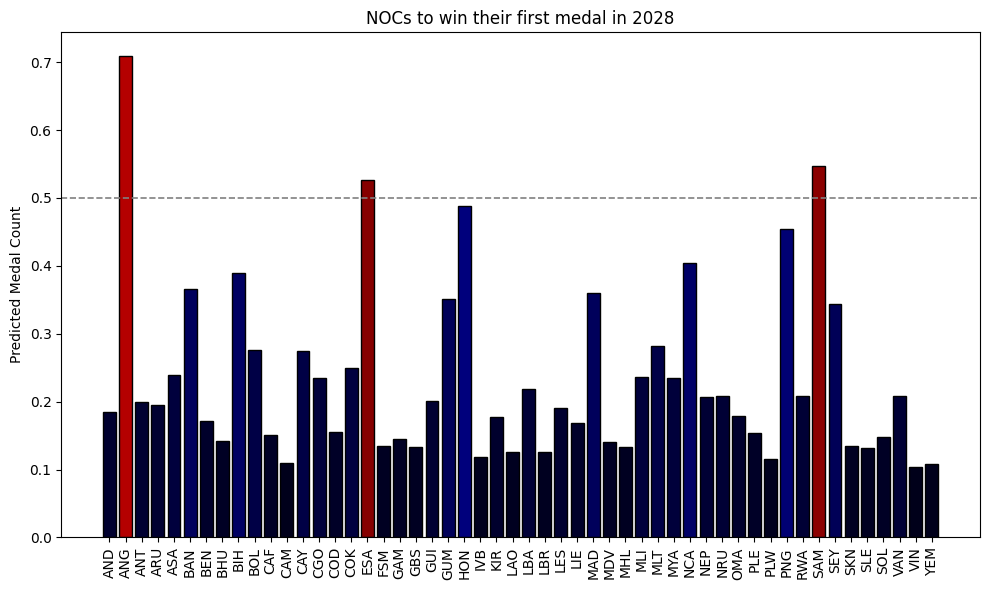

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # 加载data/olympic_medals_with_type.npy
# data = np.load('data/olympic_medals_with_type.npy')
# # 计算每个国家获得的奖牌总数，即对前两维求和
# medal_counts = np.sum(data, axis=(0, 1))
# # 找到奖牌总数为0的国家
# nocs_never = np.where(medal_counts == 0)[0]
# print(len(nocs_never))


# # 获得nocs_never的预测值
# nocs_never_pred = pred_medals[nocs_never] * 5
# print(nocs_never_pred)
# # 找到预测值大于0.1的国家对应的索引
# nocs_never_pred_idx = np.where(nocs_never_pred > 0.1)[0]
# print(len(nocs_never_pred_idx))
# print(nocs_never[nocs_never_pred_idx])
# # 打印这些国家的名称
# print([idx_to_noc[idx] for idx in nocs_never[nocs_never_pred_idx]])


# colors = []
# for value in nocs_never_pred[nocs_never_pred_idx]:
#     if value > 0.5:
#         # Red gradient for values > 0.5
#         colors.append(mcolors.to_rgba(f'#{int(255 * value):02X}0000'))
#     else:
#         # Blue gradient for values <= 0.5
#         colors.append(mcolors.to_rgba(f'#0000{int(255 * value):02X}'))

# # Create the bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(nocs_never_pred_idx)), nocs_never_pred[nocs_never_pred_idx], color=colors, edgecolor='black')

# # Add horizontal dashed line at 0.5
# plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.2)

# # Customize the x-ticks
# plt.xticks(range(len(nocs_never_pred_idx)), [idx_to_noc[idx] for idx in nocs_never[nocs_never_pred_idx]], rotation=90)


# # Add labels and title
# # plt.xlabel('Country')
# plt.ylabel('Predicted Medal Count')
# plt.title('NOCs to win their first medal in 2028')

# # Show the plot
# plt.tight_layout()
# plt.show()











